# DS-SF-23 | Lab 09 | Introduction to Logistic Regression | Answer Key

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, cross_validation

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'bank-marketing.csv'))

In [3]:
df.head()

,age,job,marital,education,default,...,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,...,1,-1,0,unknown,no
1,33,services,married,secondary,no,...,1,339,4,failure,no
2,35,management,single,tertiary,no,...,1,330,1,failure,no
3,30,management,married,tertiary,no,...,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,...,1,-1,0,unknown,no


The dataset is related to the direct marketing campaigns (by phone) of a Portuguese banking institution.  The classification goal is to predict if the client will subscribe a term deposit (variable y).

Attribute Information:

- Input variables:
  - [Bank client data]
    - `age` (numeric)
    - `job`: type of job (categorical)
    - `marital`: marital status (categorical)
      - Note: `divorced` means divorced or widowed)
    - `education` (categorical)
    - `default`: has credit in default? (categorical)
    - `balance`: bank account balance (\$)
    - `housing`: has housing loan? (categorical)
    - `loan`: has personal loan? (categorical)
  - [Data related with the last contact of the current campaign]
    - `contact`: contact communication type (categorical)
    - `month`: last contact month of year (categorical)
    - `day_of_week`: last contact day of the week (categorical)
    - `duration`: last contact duration, in seconds (numeric)
      - Important note: this attribute highly affects the output target (e.g., if `duration = 0` then `y = 'no'`). Yet, the duration is not known before a call is performed.  Also, after the end of the call y is obviously known.  Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  - [Other attributes]
    - `campaign`: number of contacts performed during this campaign and for this client (numeric)
    - `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric)
      - 999 means client was not previously contacted
    - `previous`: number of contacts performed before this campaign and for this client (numeric)
    - `poutcome`: outcome of the previous marketing campaign (categorical)

- Output variable (desired target):
  - `y`: has the client subscribed a term deposit? (binary)

## Our goal is to develop a model the best predicts the outcome `y`, the success of the marketing campaign

> ## Question 1.  Remove the categorical variables with the most number of distinct values

In [4]:
len(df.job.value_counts())

12

Answer: `job` is the variable with the most number of distinct values (12)

In [5]:
df.drop('job', axis = 1, inplace = True)

> ## Question 2.  Recode all `yes`/`no` categorical variables with `0` as the most frequent value (then also append `"_no"` to the variable name), and `1` for the other (then leave the name unchanged)

### `default`

In [6]:
df.default.value_counts()

no     4445
yes      76
Name: default, dtype: int64

In [7]:
df.default = df.default.apply(lambda value: 0 if value == 'no' else 1)

In [8]:
df.default.value_counts()

0    4445
1      76
Name: default, dtype: int64

### `housing`

In [9]:
df.housing.value_counts()

yes    2559
no     1962
Name: housing, dtype: int64

In [10]:
df['housing_no'] = df.housing.apply(lambda value: 0 if value == 'yes' else 1)

In [11]:
df.drop('housing', axis = 1, inplace = True)

In [12]:
df.housing_no.value_counts()

0    2559
1    1962
Name: housing_no, dtype: int64

### `loan`

In [13]:
df.loan.value_counts()

no     3830
yes     691
Name: loan, dtype: int64

In [14]:
df.loan = df.loan.apply(lambda value: 0 if value == 'no' else 1)

In [15]:
df.loan.value_counts()

0    3830
1     691
Name: loan, dtype: int64

### `y`

In [16]:
df.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [17]:
df.y = df.y.apply(lambda value: 0 if value == 'no' else 1)

In [18]:
df.y.value_counts()

0    4000
1     521
Name: y, dtype: int64

> ## Question 3.  Create binary/dummy variables for the other categorical variables

In [19]:
marital_df = pd.get_dummies(df.marital, prefix = 'marital')
education_df = pd.get_dummies(df.education, prefix = 'education')
contact_df = pd.get_dummies(df.contact, prefix = 'contact')

df = df.join([marital_df, education_df, contact_df])

> ## Question 4.  What should be your baseline for these binary variables (namely, which binary variables should you not include in your model)?

In [20]:
df.marital.value_counts()

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

In [21]:
df.education.value_counts()

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

In [22]:
df.contact.value_counts()

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

Answer: `married` (`marital`), `secondary` (`education`), `cellular` (`contact`) as they are the most frequent values in their respective variable.

In [23]:
df.drop(['marital', 'education', 'contact'], axis = 1, inplace = True)

> ## Question 5.  What input variable in the dataset seems to predict the outcome quite well.  Why?

In [24]:
df.corr().y.sort_values(ascending = False).head()

y                   1.000000
duration            0.401118
contact_cellular    0.118761
previous            0.116714
housing_no          0.104683
Name: y, dtype: float64

Answer: `duration` but as seen in the documentation (you've read it, right?), we should discard it when predicting a model

In [25]:
df.drop('duration', axis = 1, inplace = True)

> ## Question 6.  Split the dataset into a training set (60%) and a testing set (the rest)

In [26]:
train_df = df.sample(frac = .6, random_state = 0)
test_df = df.drop(train_df.index)

> ## Question 7.  Run a logistic regression with `age`, `marital` (the dummies), `default`, `balance`, `housing`, `loan`, `campaign`, `pdays`, `previous`?

In [27]:
train_df.columns

Index([u'age', u'default', u'balance', u'loan', u'day', u'month', u'campaign',
       u'pdays', u'previous', u'poutcome', u'y', u'housing_no',
       u'marital_divorced', u'marital_married', u'marital_single',
       u'education_primary', u'education_secondary', u'education_tertiary',
       u'education_unknown', u'contact_cellular', u'contact_telephone',
       u'contact_unknown'],
      dtype='object')

In [28]:
names_X = ['age', 'marital_single', 'marital_divorced',
    'default', 'balance', 'housing_no',
    'loan', 'campaign', 'pdays', 'previous']

def X_y(df):
    X = df[ names_X ]
    y = df.y
    return X, y

train_X, train_y = X_y(train_df)
test_X, test_y = X_y(test_df)

In [29]:
model = linear_model.LogisticRegression()
model.fit(train_X, train_y)

print 'intercept    =', model.intercept_
print 'coefficients =', model.coef_

intercept    = [-2.87343427]
coefficients = [[  9.65924804e-03   4.65735742e-01   4.44650261e-01  -1.53217137e-02
    2.37968322e-05   6.64485936e-01  -7.05043622e-01  -6.20171748e-02
    1.64893652e-03   7.62198601e-02]]


> ## Question 8.  What is your training error?  What is your generalization error?  Does it make sense?

In [30]:
print 'training misclassification =', model.score(train_X, train_y)
print 'testing  misclassification =', model.score(test_X, test_y)

training misclassification = 0.883155178769
testing  misclassification = 0.884955752212


Answer: The generalization error is higher than the training error.  Yes, this make sense since the model should better fit the training set.

> ## Question 9.  Interpret your coefficients. (At least `marital_single`, `campaign`, and `default`).  Does your interpretation  make sense?

In [31]:
zip(names_X, np.exp(model.coef_[0]) - 1)

[('age', 0.0097060491390525971),
 ('marital_single', 0.59318593164440014),
 ('marital_divorced', 0.55994452735354372),
 ('default', -0.015204933478905169),
 ('balance', 2.3797115362711452e-05),
 ('housing_no', 0.94349118544422028),
 ('loan', -0.50591297930693568),
 ('campaign', -0.060133255340787173),
 ('pdays', 0.0016502967673990288),
 ('previous', 0.079199821025339512)]

Answer: The odds that single individuals are targeted successfully by this campaign is 59% more than married people.  Perhaps if people are married they need to consult with their spouse but singles can decide on themselves.

Every extra time a client is contacted - the odds of usefulness of the marketing campaign decreases by 6%; maybe clients get frustrated overtime.

The odds of effectiveness of this campaign on those people who have not defaulted on their loans is 1.5% less than those who did.  This may suggest that those who are responsible borrowers are more careful with how to respond to bank offers.

> ## Question 10.  What is your prediction for a 30 years old single female, a homeowner with a \$1,000 balance in the bank, without a loan, who has never been contacted before, and who has never defaulted.

In [32]:
predict_x = [30, 1, 0, 0, 1000, 1, 0, 3, 999, 0]

print model.predict(predict_x)
print model.predict_proba(predict_x)

[1]
[[ 0.49210122  0.50789878]]


Answer: The campaign will be successful with a 51% success.

> ## Question 11.  Normalize your variables.  (You can reuse the function from the previous lab)

In [33]:
def normalize(x):
    min = x.min()
    max = x.max()
    return (x - min) / (max - min)

train_df[ names_X ] = train_df[ names_X ].apply(normalize)

> ## Question 12.  Let's do some regularization.  Use 10-fold cross validation to find the best tuning parameter `c`

(Hint: check the documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

Note: `c` is just the inverse of $\lambda$ - the smaller $c$, the stronger the regularization. The smaller values choose less variables

(Hint 2: First try c = 10 ^ i with i = -10 ... 10)

In [34]:
c_df = pd.DataFrame({'index': np.linspace(-10, 10, 21)})

c_df['c'] = c_df['index'].apply(lambda index: 10 ** index)

def optimize_c(c):
    model = linear_model.LogisticRegression(C = c)
    return cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

c_df['Score'] = c_df.c.apply(optimize_c)

In [35]:
c_df

,index,c,Score
0,-10.0,1.000000e-10,0.815353
1,-9.0,1.000000e-09,0.815351
2,-8.0,1.000000e-08,0.821244
3,-7.0,1.000000e-07,0.848147
4,-6.0,1.000000e-06,0.883529
...,...,...,...
16,6.0,1.000000e+06,0.882789
17,7.0,1.000000e+07,0.882789
18,8.0,1.000000e+08,0.882789
19,9.0,1.000000e+09,0.882789


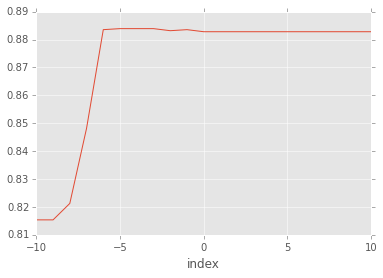

In [36]:
c_df.set_index('index').Score.plot()

Answer: It sounds like our precision is best at between $10^{-7}$ and $10^{-5}$.  Let's refine a bit...

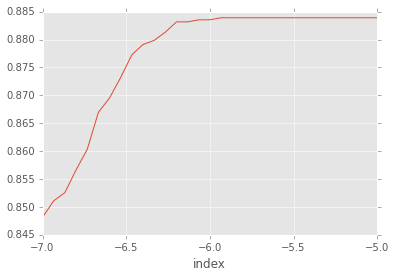

In [37]:
c_df = pd.DataFrame({'index': np.linspace(-7, -5, 31)})

c_df['c'] = c_df['index'].apply(lambda index: 10 ** index)

def optimize_c(c):
    model = linear_model.LogisticRegression(C = c)
    return cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

c_df['Score'] = c_df.c.apply(optimize_c)

c_df.set_index('index').Score.plot()

Answer: We pick $c = 10^{-6.25}$

> ## Question 13.  Now use the best `c` you found above and repeat your analysis; look over your coefficients

In [38]:
model = linear_model.LogisticRegression(C = 10 ** -6.25)
model.fit(train_X, train_y)

LogisticRegression(C=5.6234132519e-07, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [39]:
zip(np.exp(model.coef_[0]) - 1, names_X)

[(-0.011011762372567624, 'age'),
 (-7.0557339100441041e-05, 'marital_single'),
 (-2.8665938689442783e-05, 'marital_divorced'),
 (-8.0380655846923332e-06, 'default'),
 (-0.00031406369914976917, 'balance'),
 (-9.1757007479431607e-05, 'housing_no'),
 (-6.0637502554694578e-05, 'loan'),
 (-0.00090878086421219972, 'campaign'),
 (-0.0017350425075352005, 'pdays'),
 (-1.1732079805426565e-05, 'previous')]

> ## Question 14.  If you want to drop 3 variables from your analysis, which variables will you choose?

In [40]:
# sort to looks at the values; pay attention to negative coefficients!

sorted(zip(abs(np.exp(model.coef_[0]) - 1), names_X))

[(8.0380655846923332e-06, 'default'),
 (1.1732079805426565e-05, 'previous'),
 (2.8665938689442783e-05, 'marital_divorced'),
 (6.0637502554694578e-05, 'loan'),
 (7.0557339100441041e-05, 'marital_single'),
 (9.1757007479431607e-05, 'housing_no'),
 (0.00031406369914976917, 'balance'),
 (0.00090878086421219972, 'campaign'),
 (0.0017350425075352005, 'pdays'),
 (0.011011762372567624, 'age')]

Answer: `default`, `previous`, and `marital_divorced` since they have the smallest coefficients under the optimal `c`.